# Rekonstrukcija modela iz rada
rad: https://arxiv.org/pdf/1908.07414v1.pdf

## Imports and load data

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import keras_tuner as kt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords', download_dir='./nltk')
nltk.download('wordnet', download_dir='./nltk')

[nltk_data] Downloading package stopwords to ./nltk...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to ./nltk...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [5]:
# split data into train and test set
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

# separate data from labels
x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']

## Preprocessing

In [6]:
# basic preprocessing
# appostophe words
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
  arr = []
  for row in headline.values:
      for word in row:
          if word in appos.keys():
              row = row.replace(word, appos[word])
  return headline

def to_lowercase(headline):
  headline = headline.apply(lambda x: x.lower())
  return headline

def remove_stop_words(headline):
  stop = stopwords.words('english')
  headline = headline.apply(lambda x: [item for item in x.split() if item not in stop])
  headline = headline.apply(lambda x: ' '.join(map(str, x)))
  return headline

def remove_numbers(headline):
   headline = headline.str.replace('\d+', '')
   return headline

def remove_punctuation(headline):
  headline = headline.str.replace('[^\w\s]','')
  return headline

def remove_whitespaces(headline):
  headline = headline.str.strip()
  return headline
  
def apply_stemming(headline):
   #stemmer = SnowballStemmer("english")
   #stemmer = LancasterStemmer()
   stemmer = PorterStemmer()
   headline = headline.apply(lambda x: [stemmer.stem(y) for y in x.split()])
   return headline

def apply_lemmatization(headline):
   lemmatizer = WordNetLemmatizer()
   headline = headline.apply(lambda x: ' '.join(map(str, x)))
   return headline

def replace_quote(headline):
  headline = headline.str.replace("’", "'")
  return headline

def delete_quotes(headline):
  headline = headline.str.replace("'", "")
  return headline

def preprocess(headlines):
  headlines = to_lowercase(headlines)
  headlines = remove_numbers(headlines)
  headlines = replace_quote(headlines)
  headlines = transform_appos(headlines)
  headlines = remove_punctuation(headlines)
#   df["headline"] = delete_quotes(df['headline'])
  #df['headline'] = remove_stop_words(df['headline'])
  df['headline'] = remove_whitespaces(df['headline'])
  #df['headline'] = apply_stemming(df['headline'])
  #df['headline'] = apply_lemmatization(df['headline'])

  return headlines

In [7]:
# apply preprocessing to train set
x_train = preprocess(x_train)
# apply preprocessing to test set
x_test = preprocess(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.


In [8]:
# preprocessing - tokenization
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_token = "<OOV>"

x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']



tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

# Need this block to get it to work with TensorFlow 2.x
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Create and train hyper model

In [11]:
# create model
def model_builder():
    model = Sequential()
    
    embedding_dim = 300
    embedding_layer = layers.Embedding(vocab_size, output_dim=embedding_dim, input_length=max_length)
    model.add(embedding_layer)

    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D())

    model.add(layers.Bidirectional(layers.LSTM(units=128, activation='relu')))

    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = optimizers.Adam()
    loss = losses.BinaryCrossentropy()
    metrics=['accuracy']
    model.compile(optimizer, loss, metrics)

    return model

In [12]:
# train the model only from model builder
model = model_builder()
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
save_best_weights = callbacks.ModelCheckpoint('checkpoints/word2vec', 
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=True)
history = model.fit(train_padded, 
          y_train, 
          epochs=20, 
          validation_split=0.2, 
          batch_size=64,
          callbacks=[stop_early, save_best_weights])

Epoch 1/20
268/268 [==============================] - 100s 359ms/step - loss: 0.5765 - accuracy: 0.7846 - val_loss: 0.3202 - val_accuracy: 0.8657
Epoch 2/20
268/268 [==============================] - 89s 332ms/step - loss: 0.1876 - accuracy: 0.9262 - val_loss: 0.3325 - val_accuracy: 0.8584
Epoch 3/20
268/268 [==============================] - 89s 330ms/step - loss: 0.0608 - accuracy: 0.9786 - val_loss: 0.4628 - val_accuracy: 0.8533
Epoch 4/20
268/268 [==============================] - 87s 326ms/step - loss: 0.0164 - accuracy: 0.9942 - val_loss: 0.8621 - val_accuracy: 0.8465
Epoch 5/20
268/268 [==============================] - 87s 325ms/step - loss: 17.3993 - accuracy: 0.9887 - val_loss: 0.5833 - val_accuracy: 0.8182
Epoch 6/20
268/268 [==============================] - 88s 327ms/step - loss: 0.0765 - accuracy: 0.9730 - val_loss: 0.6121 - val_accuracy: 0.8341


In [13]:
# evaluate the model from the best epoch
model = model_builder()
model.load_weights('checkpoints/word2vec')
loss, acc = model.evaluate(test_padded, y_test, batch_size=64)

84/84 [==============================] - 3s 26ms/step - loss: 0.3262 - accuracy: 0.8618


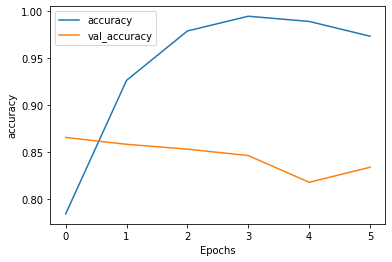

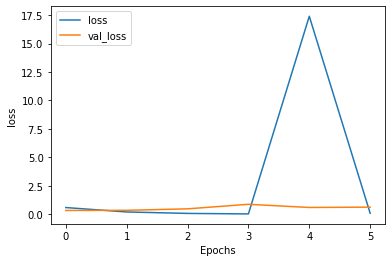

In [14]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaulate on test set

In [15]:
# loss and accuracy
loss, acc = model.evaluate(test_padded, y_test, batch_size=64, verbose=0)
print(f'Loss is: {loss} \nAcc is: {acc} \n')

# f1 score
y_pred = (model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Loss is: 0.32620325684547424 
Acc is: 0.8618494868278503 

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2982
           1       0.83      0.87      0.85      2360

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



## Predict sarcasm with new incoming sentences

In [16]:
# predict
sentences = ["It’s okay if you don’t like me. Not everyone has good taste.",
             "Today is a nice day."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
model.predict(padded)

array([[0.8756037 ],
       [0.02812984]], dtype=float32)